# Model specification

## Model definition

We have 2 interconnected neural populations, one excitatory ($E$) and one inhibitory ($I$), which interactions are parametrized by coupling coefficients $c_{xy} \in \mathbb{R}^+$ with $x,y \in \{e,i\}$. So, for a given population $x$ we have the following local coupling: $\big(c_{xe}E-c_{xi}I\big)$.

[Note: capital letters $E$, $I$ refer to state variables, and lower case letters $e$, $i$ specify parameter association to neural population] 

In the case of a coupled system, the excitatory population (potentially) receives input from other excitatory populations elsewhere in the brain through a network input term $N_{input}(t)$ that can be set to 0 if modelling a single node dynamics. 

Here we will consider it to be defined for a given node $n$ in a network $M$ as delayed coupling propagated through some connectivity matrices of coupling strength ($A$) and axonal distance ($D$) e.g., derived from diffusion weighted MRI (DWI) and parametrized by a global scaling factor ($G$) and a conduction speed term ($K$): $$N_{input}(t) = G\sum_{m\in M}A_{nm}E_m(t-\frac{D_{nm}}{K})$$ 

The input to each neural population is subject to a threshold parameter $\theta_x$ and passed through a sigmoid activation function  $S_x(X)$ with a parametrized slope $a_x$: 
 
$$S_x(X) = \frac{1}{1+e^{-a_x \cdot x}}, \hspace{0.25mm} X \in \{E,I\} $$


The activation response is the scaled by a parametrized refractory term $(k_x - r_x x)$ enabling only some subset of the neural population to respond to the input (unless set to $k_x=1,r_x=0$). 

Finally, the temporal scale for the dynamics of each population is parametrized by the time constants $\tau_x$. 

This gives us the following system:
\begin{align*}
\tau_e\frac{dE}{dt} &= -E + (k_e - r_e E) \cdot S_e\big(c_{ee}E-c_{ei}I + N_{input}(t) - \theta_e\big)\\
\tau_i\frac{dI}{dt} &= -I + (k_i - r_i I) \cdot S_i\big(c_{ie}E-c_{ii}I - \theta_i\big)
\end{align*}


## Jacobian of the system

The jacobian of the system is defined as the matrix
\begin{align*}
    J &= 
    \begin{pmatrix} 
        \frac{d\dot{E}}{dE}  & \frac{d\dot{E}}{dI} \\
        \frac{d\dot{I}}{dE}  & \frac{d\dot{I}}{dI}  
    \end{pmatrix}\\
\end{align*}

[Note: $\dot{X}=\frac{dX}{dt}$]

Which entries can be found to be defined by
\begin{align*}
\tau_e\frac{d\dot{E}}{dE} &= -1 + - \frac{r_e}{\left(1+e^{-a_e \cdot \left(c_{ee}E-c_{ei}I + N_{input}(t) - \theta_e\right)}\right)} + (k_e - r_e E)\cdot\frac{-a_e c_{ee} \cdot e^{-a_e \cdot \left(c_{ee}E-c_{ei}I + N_{input}(t) - \theta_e\right)}}{\left(1+e^{-a_e \cdot \left(c_{ee}E-c_{ei}I + N_{input}(t) - \theta_e\right)}\right)^2} \\
\tau_e\frac{d\dot{E}}{dI} &= (k_e - r_e E)\cdot \frac{a_e c_{ei} \cdot e^{-a_e \cdot \left(c_{ee}E-c_{ei}I + N_{input}(t) - \theta_e\right)}}{\left(1+e^{-a_e \cdot \left(c_{ee}E-c_{ei}I + N_{input}(t) - \theta_e\right)}\right)^2}\\
\tau_i\frac{d\dot{I}}{dE} &= (k_i - r_i I)\cdot \frac{-a_i c_{ie} \cdot e^{-a_i \cdot \left(c_{ie}E-c_{ii}I - \theta_i\right)}}{\left(1+e^{-a_i \cdot \left(c_{ie}E-c_{ii}I - \theta_i\right)}\right)^2}\\
\tau_i\frac{d\dot{I}}{dI} &= -1 + - \frac{r_i}{\left(1+e^{-a_i \cdot \left(c_{ie}E-c_{ii}I - \theta_i\right)}\right)} + (k_i - r_i I)\cdot \frac{a_i c_{ii} \cdot  e^{-a_i \cdot \left(c_{ie}E-c_{ii}I - \theta_i\right)}}{\left(1+e^{-a_i \cdot \left(c_{ie}E-c_{ii}I - \theta_i\right)}\right)^2}
\end{align*}
The full derivation might be available in the "detailed_derivations" folder if I ever get to it at some point.

## Nullclines

The nullcines of the system can be found to be 
\begin{align*}
    E_{null} &=\frac{-\ln \left(\frac{-r_i I+k_i}{I}-1\right)+a_i c_{ii} I+a_i \theta_i}{a_i c_{ie}}\\
    I_{null} &=-\frac{-\ln \left(\frac{-r_e E+k_e}{E}-1\right)-a_e c_{ee}E+a_e \theta_e -a_e N_{input}(t) }{a_e c_{ei}}\\
\end{align*}

## Fixed point localization

Given that the intersection of the nullclines does not have an analytical solution (at least to my knowledge), a numerical estimation is required. We can define functions $h_E(E)$, $h_I(I)$ and apply the newton root finding method on $h_X(X)$ with $(X,Y) \in \{(E,I),(I,E)\}$:
\begin{align*}
    h_X(X) &= X - X_{null}\big(Y_{null}(X)\big)\\
    X_{k+1} &= X_k - \frac{h_X(X_k)}{\frac{dh_X}{dX}\big|_{X_k}}\\
    \text{Where,}\hspace{0.3mm}\frac{dh_X}{dX}\bigg|_X &= \frac{d}{dX}\bigg[X - X_{null}\big(Y_{null}(X)\big)\bigg]\\
    & = 1 - \frac{d}{dX}\bigg[X_{null}\big(Y_{null}(X)\big)\bigg]\\
    &= 1 -  \frac{dX_{null}}{dY_{null}}\bigg|_{Y_{null}(X)}  \frac{dY_{null}}{dX}\bigg|_{X}\\    
\end{align*}

This requires us to find the derivatives of the nullclines which can be found to be:

\begin{align*}
    \frac{dE_{null}}{dI}&=\frac{k_i + c_{ii}+\theta_i}{1 + a_i c_{ie}^2 k_i I-a_i c_{ie}^2I^2 (r_i +1 )}\\
    \frac{dI_{null}}{dE}&=\frac{k_e - c_{ee}+\theta_e - N_{input}(t)}{1 + a_e c_{ei}^2 k_e E-a_e c_{ei}^2E^2 (r_e +1 )}\\
\end{align*}
The full derivation might be available in the "detailed_derivations" folder if I ever get to it at some point.

# Model Code

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dcp 
parameter_index_mapping = {
    "c_ee": 0, "c_ei": 1, "c_ie": 2, "c_ii": 3, 
    "tau_e": 4, "tau_i": 5,
    "theta_e": 6, "theta_i": 7,
    "a_e": 8, "a_i": 9,
    "k_e": 10, "k_i": 11, "r_e": 12, "r_i": 13,
    "noise_E": 14, "noise_I": 15,
}
parameter_names = [par for par in parameter_index_mapping]

## Model dynamics

In [2]:
@numba.njit
def fn_Edot(E,I, params, global_input):
    return (-E + (params[10] - params[12] * E) * 1.0 / (1 + np.exp(-params[8] * (params[0] * E - params[1] * I - params[6] + global_input))))/params[4]
@numba.njit
def fn_Idot(E, I, params):
    return (-I + (params[11] - params[13] * I) * 1.0 / (1 + np.exp(-params[9] * (params[2] * E - params[3] * I - params[7]))))/params[5]

## Jacobian

In [3]:
@numba.njit
def fn_Edot_E(E, I, params, global_input):
    Edot_E = 1/params[4] * (-1 - (params[12]/(1 + np.exp(-params[8] * (params[0] * E - params[1] * I + global_input - params[6])))) + (params[10] - params[12] * E) * (( np.exp(-params[8] * (params[0] * E - params[1] * I + global_input - params[6])) * (-params[8] * params[0]))/(1 + np.exp(-params[8] * (params[0] * E - params[1] * I + global_input - params[6])))**2))
    return Edot_E
@numba.njit
def fn_Edot_I(E, I, params, global_input):
    Edot_I = 1/params[4] * ((params[10] - params[12] * E) * (( np.exp(-params[8] * (params[0] * E - params[1] * I + global_input - params[6])) * (params[8] * params[1]))/(1 + np.exp(-params[8] * (params[0] * E - params[1] * I + global_input - params[6])))**2))
    return Edot_I
@numba.njit
def fn_Idot_E(E, I, params):
    Idot_E = 1/params[5] * ((params[11] - params[13] * I) * (( np.exp(-params[9] * (params[2] * E - params[3] * I - params[7])) * (-params[9] * params[2]))/(1 + np.exp(-params[9] * (params[2] * E - params[3] * I - params[7])))**2))
    return Idot_E
@numba.njit
def fn_Idot_I(E, I, params):
    Idot_I = 1/params[5] * (-1 - (params[13]/(1 + np.exp(-params[9] * (params[2] * E - params[3] * I - params[7])))) + (params[11] - params[13] * I) * (( np.exp(-params[9] * (params[2] * E - params[3] * I - params[7])) * (params[9] * params[3]))/(1 + np.exp(-params[9] * (params[2] * E - params[3] * I - params[7])))**2))
    return Idot_I
@numba.njit
def get_jac(E,I, params, global_input):
    Edot_E = fn_Edot_E(E, I, params, global_input)
    Edot_I = fn_Edot_I(E, I, params, global_input)
    Idot_E = fn_Idot_E(E, I, params)
    Idot_I = fn_Idot_I(E, I, params)
    return Edot_E,Edot_I,Idot_E,Idot_I

## Nullclines

In [4]:
@numba.njit
def fn_E_nullcline(I,params, global_input):
    log_component = np.log((-params[13] * I + params[11])/I -1)
    return (params[9]*params[3]*I + params[9]*params[7] - log_component)/(params[9]*params[2])
@numba.njit
def fn_I_nullcline(E,params, global_input):
    log_component = np.log((-params[12] * E + params[10])/E -1)
    return -(params[8]*params[6] - params[8]*params[0]*E - log_component - params[8]*global_input)/(params[8]*params[1])

## Fixed point localization

### h functions

In [5]:

@numba.njit
def fn_h_E(E, params, global_input):
    return E - fn_E_nullcline(fn_I_nullcline(E, params, global_input), params, global_input)

@numba.njit
def fn_h_I(I, params, global_input):
    return I - fn_I_nullcline(fn_E_nullcline(I, params, global_input), params, global_input)

@numba.njit
def fn_E_nullcline_prime(I,params, global_input):
    numerator = params[11] + params[3] + params[7]
    denominator = 1 + params[9] * params[2]**2 * params[11] * I - params[9] * params[2]**2 * I**2 * (params[13] + 1)
    return numerator/denominator
@numba.njit
def fn_I_nullcline_prime(E,params, global_input):
    numerator = params[10] - params[0] + params[6] - global_input
    denominator = 1 + params[8] * params[1]**2 * params[10] * E - params[8] * params[1]**2 * E**2 * (params[12] + 1)
    return numerator/denominator

@numba.njit
def fn_h_E_prime(E,params, global_input):
    dInull_dE = fn_I_nullcline_prime(E,params, global_input)
    Inull_E = fn_I_nullcline(E,params, global_input)
    dE_null_dI_at_Inull_E = fn_E_nullcline_prime(Inull_E,params, global_input)
    return 1 - dE_null_dI_at_Inull_E * dInull_dE

@numba.njit
def fn_h_I_prime(I,params, global_input):
    dEnull_dI = fn_E_nullcline_prime(I,params, global_input)
    Enull_I = fn_E_nullcline(I,params, global_input)
    dI_null_dE_at_Enull_I = fn_I_nullcline_prime(Enull_I,params, global_input)
    return 1 - dI_null_dE_at_Enull_I * dEnull_dI

### Newton step

In [6]:
@numba.njit
def fn_newton_step_h_E(E, params, global_input, damp = 1.0):
    h_E = fn_h_E(E, params, global_input)
    h_E_prime = fn_h_E_prime(E, params, global_input)
    return E - damp * h_E/h_E_prime
@numba.njit
def fn_newton_step_h_I(I, params, global_input, damp = 1.0):
    h_I = fn_h_I(I, params, global_input)
    h_I_prime = fn_h_I_prime(I, params, global_input)
    return I - damp * h_I/h_I_prime

@numba.njit
def newton_iterate_h_E(E_0,params, global_input, damp = 0.25, n_iters = 10000):
    E_vals = np.zeros((n_iters+1,params.shape[-1]))
    I_vals = np.zeros((n_iters+1,params.shape[-1]))
    E_vals[0] = E_0
    I_vals[0] =  fn_I_nullcline(E_vals[0],params,global_input)
    for newt_step in range(n_iters):
        E_vals[newt_step+1] = fn_newton_step_h_E(E_vals[newt_step], params, global_input, damp = damp)
        I_vals[newt_step+1] =  fn_I_nullcline(E_vals[newt_step+1],params,global_input)
    return E_vals, I_vals

@numba.njit
def newton_iterate_h_I(I_0,params, global_input, damp = 0.25, n_iters = 10000):
    E_vals = np.zeros((n_iters+1,params.shape[-1]))
    I_vals = np.zeros((n_iters+1,params.shape[-1]))
    I_vals[0] = I_0
    E_vals[0] =  fn_E_nullcline(I_vals[0],params,global_input)
    for newt_step in range(n_iters):
        I_vals[newt_step+1] = fn_newton_step_h_I(I_vals[newt_step], params, global_input, damp = damp)
        E_vals[newt_step+1] =  fn_E_nullcline(I_vals[newt_step+1],params,global_input)
    return E_vals, I_vals

@numba.njit
def multi_start_h_X(parameters,state_space,n_starts,n_iters, global_input = 0, damp = 0.05, init_at_nullclines = True):
    params = parameters.T
    Es = np.zeros((n_starts,params.shape[-1])) + np.linspace(state_space[0][0],state_space[0][1],n_starts)[:,None]
    Is = np.zeros((n_starts,params.shape[-1])) + np.linspace(state_space[1][0],state_space[1][1],n_starts)[:,None]
    if init_at_nullclines:
        init_E = fn_E_nullcline(Is, params,global_input)
        init_I = fn_I_nullcline(Es, params,global_input)
    else:
        init_E = Es
        init_I = Is
    x_h_X = np.zeros((2,2,n_starts,n_iters+1,parameters.shape[0]))
    for j,E_0 in enumerate(init_E):
        x_h_X[0,0,j],x_h_X[1,0,j] = newton_iterate_h_E(E_0,params,global_input,damp=damp, n_iters = n_iters)
    for j,I_0 in enumerate(init_I):
        x_h_X[0,1,j],x_h_X[1,1,j] = newton_iterate_h_I(I_0,params,global_input,damp=damp, n_iters = n_iters)
    return x_h_X

def get_FPs(parameters,  global_input, state_space, n_starts, n_iters, unique_threshold=6, damp=0.05, init_at_nullclines=True, return_counts = False):
    x_h_X = multi_start_h_X(parameters,state_space,n_starts,n_iters, global_input=global_input, damp=damp, init_at_nullclines=init_at_nullclines)
    x_h_X[np.isnan(x_h_X)] = -1
    x_h_X[np.isinf(x_h_X)] = -1
    x_h = x_h_X.reshape((2,-1,n_iters+1,parameters.shape[0]))
    unique_points = []
    for s in range(parameters.shape[0]):
        pts, cts = np.unique(np.round(x_h[...,-1,s],unique_threshold).T,axis = 0, return_counts=True)
        pts_ok = (pts==-1).sum(-1)==0
        pts_kept = pts[pts_ok,:]
        cts_kept = cts[pts_ok]
        if return_counts:
            unique_points.append([pts_kept,cts_kept])
        else:
            unique_points.append(pts_kept)
    return unique_points


# Analysis code

In [7]:
parameters_default = np.array([
                                16.0, 12.00, 15.0, 3.00,                 #c_xx
                                8.0, 8.0,                             #tau_x
                                2.75, 3.7,                              #theta_x
                                1.3, 2.00,                               #a_x
                                1.0, 1.0, 1.0, 1.0,                     #k_x, r_x
                                0.0000e-06, 0.0000e-06                  #noise
                    ])

In [92]:
parameters = np.zeros((4,parameters_default.shape[0])) + parameters_default[None,:]
parameters[:,parameter_index_mapping["a_i"]] = 1.5
parameters[:,parameter_index_mapping["a_e"]] = 1.75
parameters[:,parameter_index_mapping["theta_i"]] = 3.5
parameters[:,parameter_index_mapping["c_ie"]] = 15.0
parameters[:,parameter_index_mapping["c_ei"]] = 8.0
parameters[:,parameter_index_mapping["theta_e"]] = np.linspace(2.25,2.75,4)

## Phase plane and fixed point localization

In [99]:
n_starts = 200
n_iters = 5000
state_space = np.array([[-0.05,0.55],[-0.05,0.55]])
unique_points = get_FPs(
                        parameters,  0, state_space, n_starts, n_iters,
                        unique_threshold=7, damp=0.05, init_at_nullclines=True, return_counts = False
            )

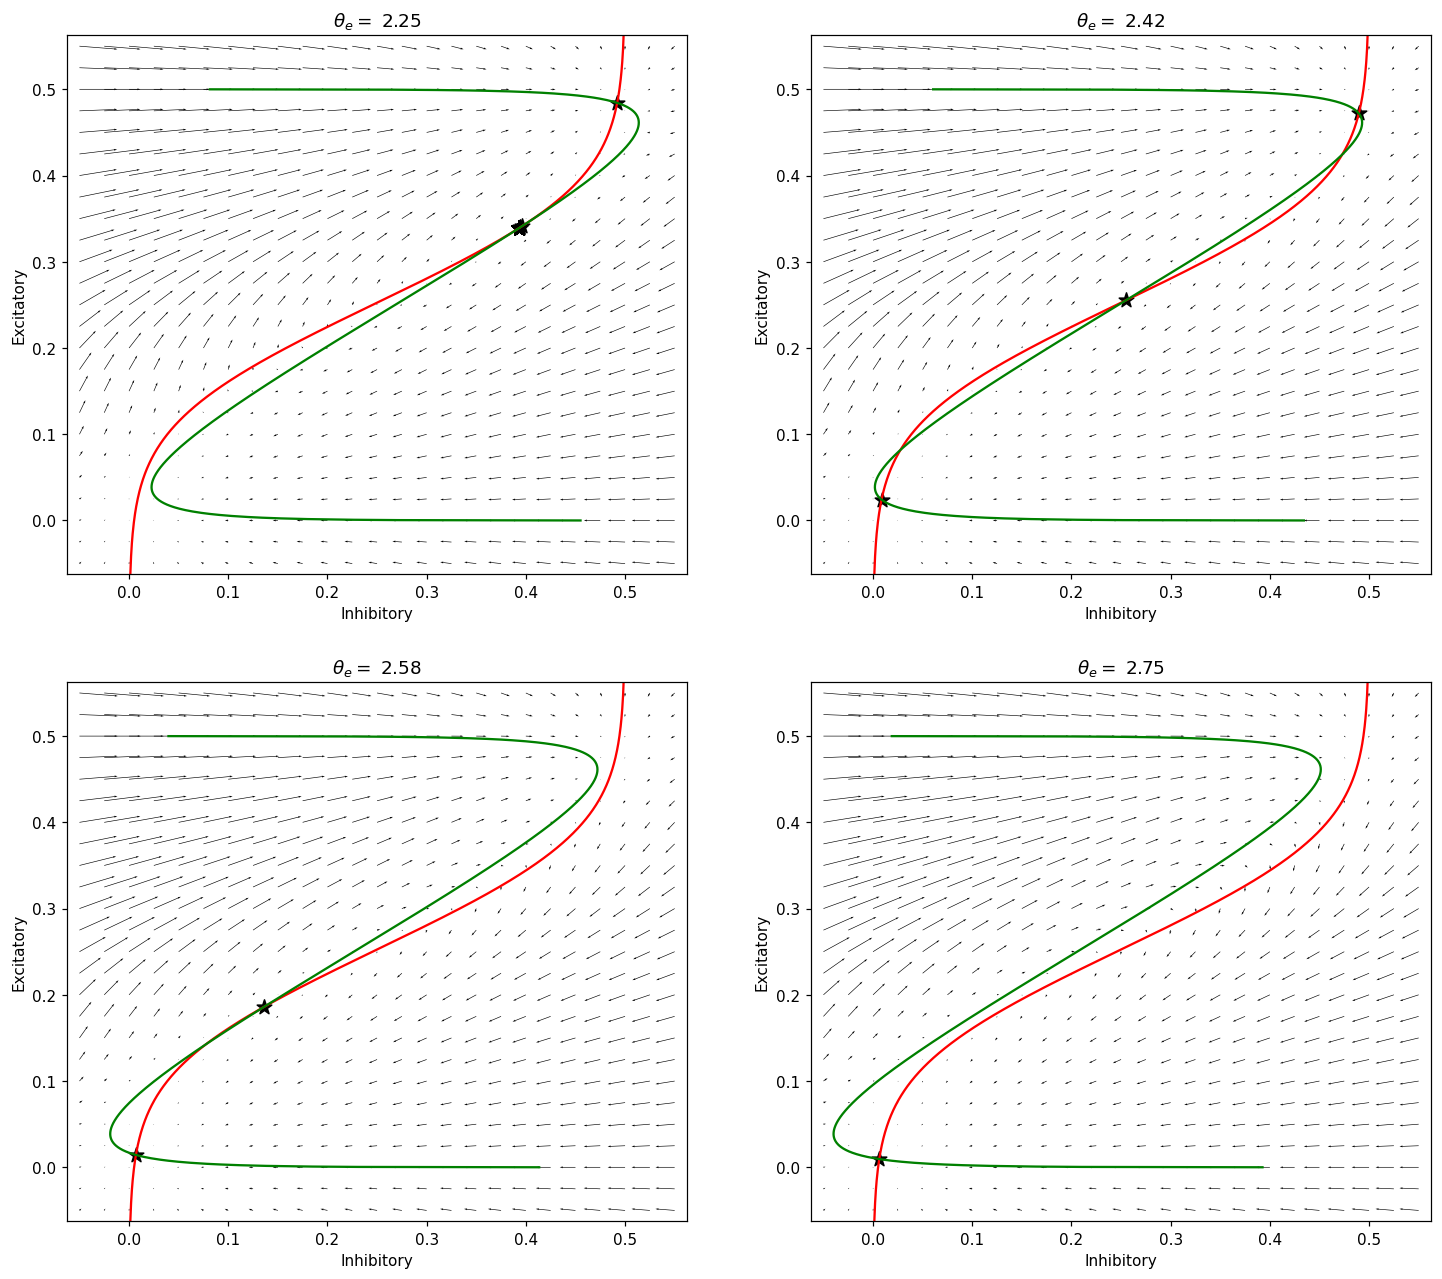

In [100]:
sim_sels = np.arange(parameters.shape[0])
state_space = np.array([[-0.05,0.55],[-0.05,0.55]])
ncols = 2
subplot_size, ms = [8,7], 100
dpi = 110
titles = ["$\\theta_e=$ "+ str(round(parameters[sim_sel,parameter_index_mapping["theta_e"]],2)) for sim_sel in sim_sels]

nrows = np.ceil(sim_sels.shape[0]/ncols).astype(int)
fig = plt.figure(figsize = (subplot_size[0]*ncols,subplot_size[1]*nrows),dpi = dpi)
for i, sim_sel in enumerate(sim_sels):
    ax = plt.subplot(nrows,ncols,1+i)
    Es = np.linspace(state_space[0][0],state_space[0][1],1500)
    Is = np.linspace(state_space[1][0],state_space[1][1],1500)
    Enull = [Is,fn_E_nullcline(Is, parameters[sim_sel],0)]#nullsE[sim_sel]
    Inull = [fn_I_nullcline(Es, parameters[sim_sel],0),Es]##nullsI[sim_sel]
    plt.plot(Enull[0],Enull[1],"-r", lw = 1.5)
    plt.plot(Inull[0],Inull[1],"-g", lw = 1.5)
    plt.scatter(unique_points[sim_sel][:,1].flatten(),unique_points[sim_sel][:,0].flatten(),c="k",marker="*",s=ms)
    Es = np.linspace(state_space[0][0],state_space[0][1],25)
    Is = np.linspace(state_space[1][0],state_space[1][1],25)
    Edot_grid = np.zeros((Es.shape[0],Is.shape[0]))
    Idot_grid = np.zeros((Es.shape[0],Is.shape[0]))
    for j in range(Es.shape[0]):
        Edot_grid[j] = fn_Edot(Es[j],Is,parameters[sim_sel],0)
        Idot_grid[j] = fn_Idot(Es[j],Is,parameters[sim_sel])
    xgrid, ygrid = np.meshgrid(Is,Es)
    flow = plt.quiver(xgrid,ygrid,Idot_grid,Edot_grid, width = 0.001, angles="xy")
    plt.xlim(state_space[1][0]-0.0125,state_space[1][1]+0.0125)
    plt.ylim(state_space[0][0]-0.0125,state_space[0][1]+0.0125)
    plt.xlabel("Inhibitory")
    plt.ylabel("Excitatory")
    plt.title(titles[i])
plt.show()

### Newton method weakness: Saddle points

In [111]:
parameters = np.zeros((4,parameters_default.shape[0])) + parameters_default[None,:]
parameters[:,parameter_index_mapping["a_i"]] = 1.5 #+ np.linspace(0,0.5,4)
parameters[:,parameter_index_mapping["a_e"]] = 1.5 + np.linspace(0,0.375,4)
parameters[:,parameter_index_mapping["theta_i"]] = 3.5
parameters[:,parameter_index_mapping["c_ie"]] = 15.0
parameters[:,parameter_index_mapping["c_ei"]] = 8.0
parameters[:,parameter_index_mapping["theta_e"]] = 2.42#np.linspace(2.25,2.75,4)

In [112]:
n_starts = 200
n_iters = 5000
state_space = np.array([[-0.05,0.55],[-0.05,0.55]])
unique_points = get_FPs(
                        parameters,  0, state_space, n_starts, n_iters,
                        unique_threshold=7, damp=0.05, init_at_nullclines=True, return_counts = False
            )

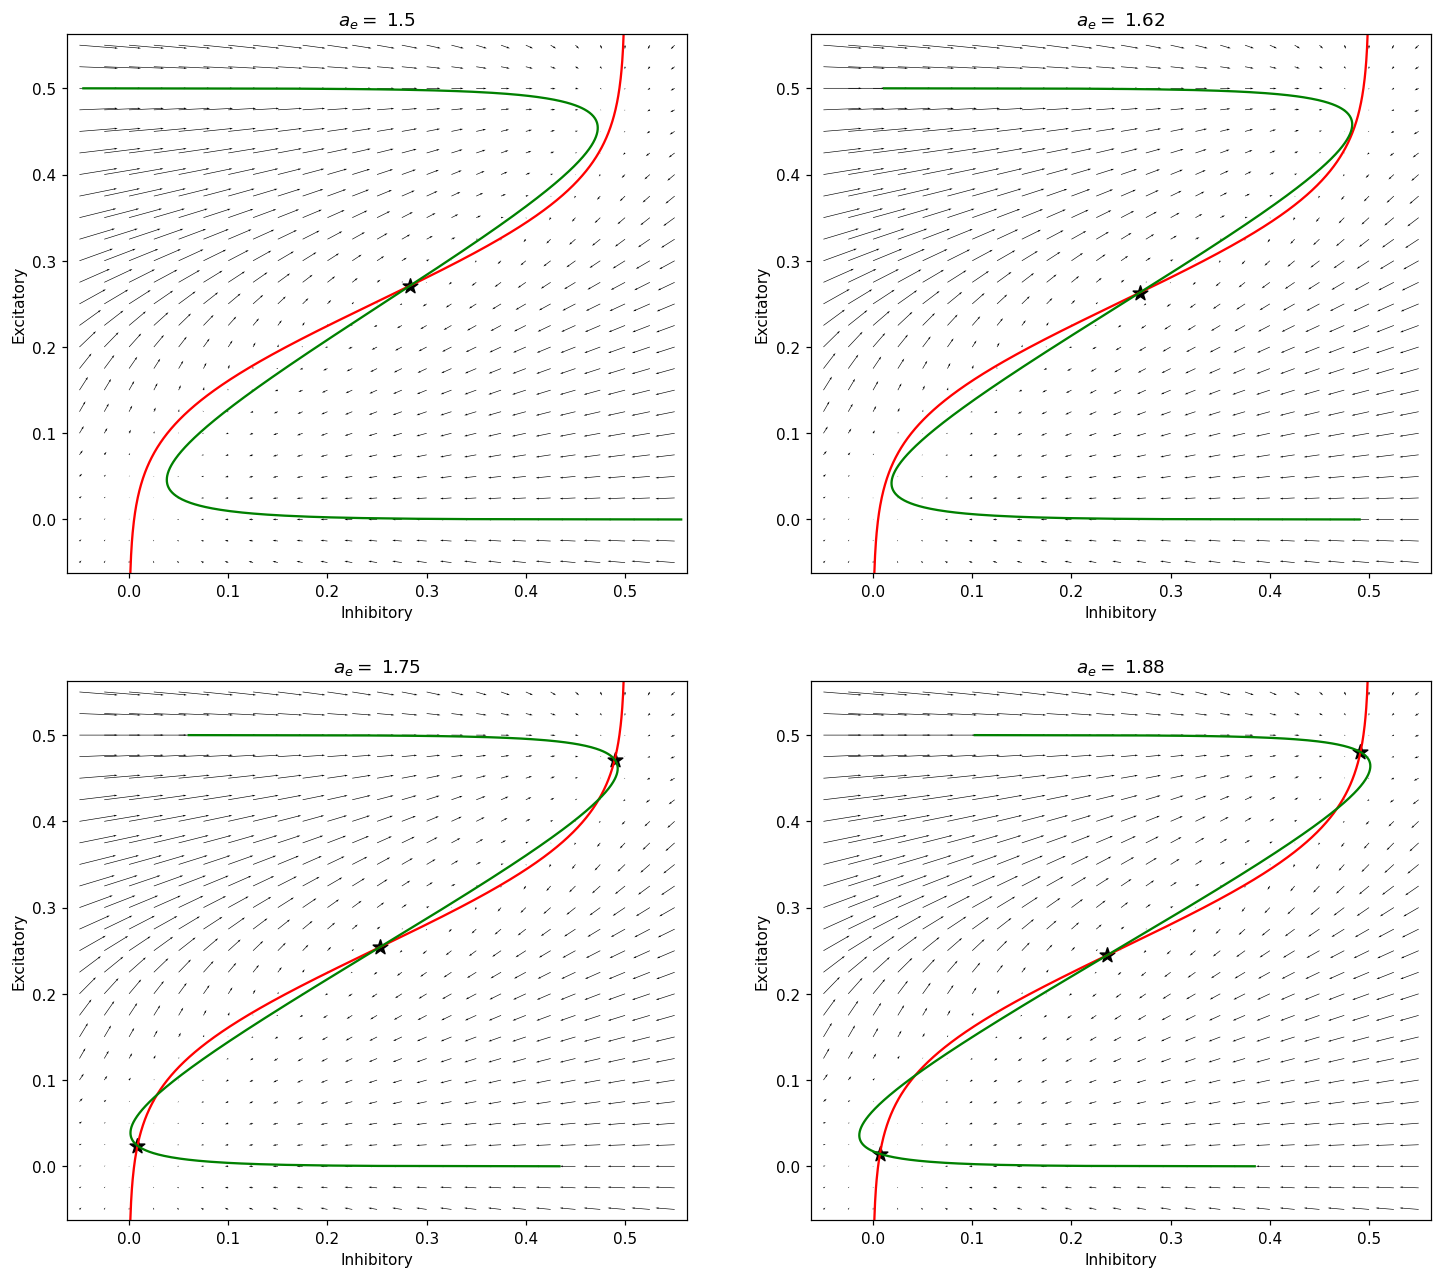

In [113]:
sim_sels = np.arange(parameters.shape[0])
state_space = np.array([[-0.05,0.55],[-0.05,0.55]])
ncols = 2
subplot_size, ms = [8,7], 100
dpi = 110
titles = ["$a_e=$ "+ str(round(parameters[sim_sel,parameter_index_mapping["a_e"]],2)) for sim_sel in sim_sels]

nrows = np.ceil(sim_sels.shape[0]/ncols).astype(int)
fig = plt.figure(figsize = (subplot_size[0]*ncols,subplot_size[1]*nrows),dpi = dpi)
for i, sim_sel in enumerate(sim_sels):
    ax = plt.subplot(nrows,ncols,1+i)
    Es = np.linspace(state_space[0][0],state_space[0][1],1500)
    Is = np.linspace(state_space[1][0],state_space[1][1],1500)
    Enull = [Is,fn_E_nullcline(Is, parameters[sim_sel],0)]#nullsE[sim_sel]
    Inull = [fn_I_nullcline(Es, parameters[sim_sel],0),Es]##nullsI[sim_sel]
    plt.plot(Enull[0],Enull[1],"-r", lw = 1.5)
    plt.plot(Inull[0],Inull[1],"-g", lw = 1.5)
    plt.scatter(unique_points[sim_sel][:,1].flatten(),unique_points[sim_sel][:,0].flatten(),c="k",marker="*",s=ms)
    Es = np.linspace(state_space[0][0],state_space[0][1],25)
    Is = np.linspace(state_space[1][0],state_space[1][1],25)
    Edot_grid = np.zeros((Es.shape[0],Is.shape[0]))
    Idot_grid = np.zeros((Es.shape[0],Is.shape[0]))
    for j in range(Es.shape[0]):
        Edot_grid[j] = fn_Edot(Es[j],Is,parameters[sim_sel],0)
        Idot_grid[j] = fn_Idot(Es[j],Is,parameters[sim_sel])
    xgrid, ygrid = np.meshgrid(Is,Es)
    flow = plt.quiver(xgrid,ygrid,Idot_grid,Edot_grid, width = 0.001, angles="xy")
    plt.xlim(state_space[1][0]-0.0125,state_space[1][1]+0.0125)
    plt.ylim(state_space[0][0]-0.0125,state_space[0][1]+0.0125)
    plt.xlabel("Inhibitory")
    plt.ylabel("Excitatory")
    plt.title(titles[i])
plt.show()

## Simulating trajectories

In [115]:
@numba.njit
def simulate_WC_node_ts(
            parameters,
            global_input = 0.0,
            length: float = 12,
            dt: float = 0.5,
            initial_conditions = np.array([0.25,0.25]),
            noise_seed: int = 42,
            store_I: bool = False,
            is_noise_log_scale = True,
            
    ):
    # Input parameters are of shape (num_nodes, num_parameters) to match parameter estimation output, but we need (num_parameters,num_nodes) to simulate
    params = np.zeros_like(parameters.T) + parameters.T
    if is_noise_log_scale:
        #nonoisepar = params[params.shape[0]-2:] == 0
        params[params.shape[0]-2:] = 10**(params[params.shape[0]-2:])
        params[-2,params[-2]==1] = 0
        params[-1,params[-1]==1] = 0 
    # Set seet
    np.random.seed(noise_seed)
    # White noise
    DE, DI = np.sqrt(2*params[-2]* dt), np.sqrt(2*params[-1]* dt)

    #Connectivity delays
    num_nodes = parameters.shape[0] 

    # Equivalent to allocating memory
    sim_length = int(1000/dt*length)

    time_series_E = np.zeros((sim_length+1, int(num_nodes)))
    time_series_I = np.zeros((3,int(num_nodes)))
    time_series_jacobian = np.empty((3,int(num_nodes), 4))
    if store_I:
        time_series_I = np.empty((sim_length+1,int(num_nodes)))
    time_series_E_temp = np.zeros((1,int(num_nodes)))
    time_series_I_temp = np.zeros((1,int(num_nodes)))
    time_series_E_corr = np.zeros((1,int(num_nodes)))
    time_series_I_corr = np.zeros((1,int(num_nodes)))
    time_series_E_noise = np.zeros((1,int(num_nodes)))
    time_series_I_noise = np.zeros((1,int(num_nodes)))

    # Set initial conditions
    time_series_E[0] = initial_conditions[0]
    time_series_I[0] = initial_conditions[1]
    
    # Heun performed in-place within the time_series_X arrays to maximize speed
    for i in range(int(1000/dt*length)-1):
        # Forward Euler
        j_0 = i
        j_1 = (i+1)
        if not store_I:
            j_0 = i%2
            j_1 = (i+1)%2
        # Calculating input from other nodes
                #               c_ee   *       E          -   c_ei    *        I           -  theta_e  + global_input
        time_series_E[i+1] = params[0] * time_series_E[i] - params[1] * time_series_I[j_0] - params[6]  + global_input
        #                       c_ie   *       E          -   c_ii    *        I           -  theta_i
        time_series_I[j_1] = params[2] * time_series_E[i] - params[3] * time_series_I[j_0] - params[7]
        #                    c_e /  1 +    exp(-  a_e     *    node input E   )      
        time_series_E[i+1] = 1.0 / (1 + np.exp(-params[8] * time_series_E[i+1]))
        #                    c_i /  1 +    exp(-  a_i     *    node input I    )
        time_series_I[j_1] = 1.0 / (1 + np.exp(-params[9] * time_series_I[j_1]))
        #                         (     k_e     -    r_e     *        E       ) *  S_e(input node E) -       E         ) /   tau_e
        time_series_E[i+1] = dt*(((params[10] - params[12] * time_series_E[i]) * time_series_E[i+1]) - time_series_E[i]) / params[4]
        #                         (     k_i     -    r_i     *        I       )  *  S_i(input node I)  -       I       )    /   tau_i 
        time_series_I[j_1] = dt*(((params[11] - params[13] * time_series_I[j_0]) * time_series_I[j_1]) - time_series_I[j_0]) / params[5] 
        time_series_E_temp = time_series_E[i] + time_series_E[i+1] 
        time_series_I_temp = time_series_I[j_0] + time_series_I[j_1]
        # Corrector point
        #                       c_ee   *       E          -   c_ei      *        I           -  theta_e  + global_input
        time_series_E_corr = params[0] * time_series_E_temp - params[1] * time_series_I_temp - params[6] + global_input
        #                       c_ie   *       E            -   c_ii    *        I           -  theta_i
        time_series_I_corr = params[2] * time_series_E_temp - params[3] * time_series_I_temp - params[7]
        #                    c_e /  1 +    exp(-  a_e     *    node input E    )  
        time_series_E_corr = 1.0 / (1 + np.exp(-params[8] * time_series_E_corr))
        #                    c_i /  1 +    exp(-  a_i     *    node input I    )  
        time_series_I_corr = 1.0 / (1 + np.exp(-params[9] * time_series_I_corr))
        #                         (   k_e     -    r_e     *           E       ) *  S_e(input node E)  -       E           ) /   tau_e
        time_series_E_corr = dt*(((params[10] - params[12] * time_series_E_temp) * time_series_E_corr) - time_series_E_temp) / params[4] 
        #                         (   k_i     -    r_i     *           I       ) *  S_i(input node I)  -       I           ) /   tau_i
        time_series_I_corr = dt*(((params[11] - params[13] * time_series_I_temp) * time_series_I_corr) - time_series_I_temp) / params[5]
        # Heun point
        time_series_E_noise = np.random.normal(0,1,size=num_nodes) *  DE 
        time_series_I_noise = np.random.normal(0,1,size=num_nodes) *  DI
        time_series_E[i+1] = time_series_E[i] + (time_series_E[i+1]+time_series_E_corr)/2 + time_series_E_noise
        time_series_I[j_1] = time_series_I[j_0] + (time_series_I[j_1]+time_series_I_corr)/2 + time_series_I_noise
    return time_series_E[:-1].T, time_series_I[:-1].T

In [133]:
parameters = np.zeros((4,parameters_default.shape[0])) + parameters_default[None,:]
parameters[:,parameter_index_mapping["a_i"]] = 1.5 #+ np.linspace(0,0.5,4)
parameters[:,parameter_index_mapping["a_e"]] = 1.5 + np.linspace(0,0.375,4)
parameters[:,parameter_index_mapping["theta_i"]] = 3.5
parameters[:,parameter_index_mapping["c_ie"]] = 15.0
parameters[:,parameter_index_mapping["c_ei"]] = 8.0
parameters[:,parameter_index_mapping["theta_e"]] = 2.42#np.linspace(2.25,2.75,4)

In [134]:
n_starts = 200
n_iters = 5000
state_space = np.array([[-0.05,0.55],[-0.05,0.55]])
unique_points = get_FPs(
                        parameters,  0, state_space, n_starts, n_iters,
                        unique_threshold=7, damp=0.05, init_at_nullclines=True, return_counts = False
            )

In [145]:
tsE, tsI = simulate_WC_node_ts(parameters, dt=0.25,length=10,is_noise_log_scale=True, store_I=True, initial_conditions=np.array([.35,0.4]))
tsE_lowE, tsI_lowE = simulate_WC_node_ts(parameters, dt=0.25,length=10,is_noise_log_scale=True, store_I=True, initial_conditions=np.array([.15,0.1]))

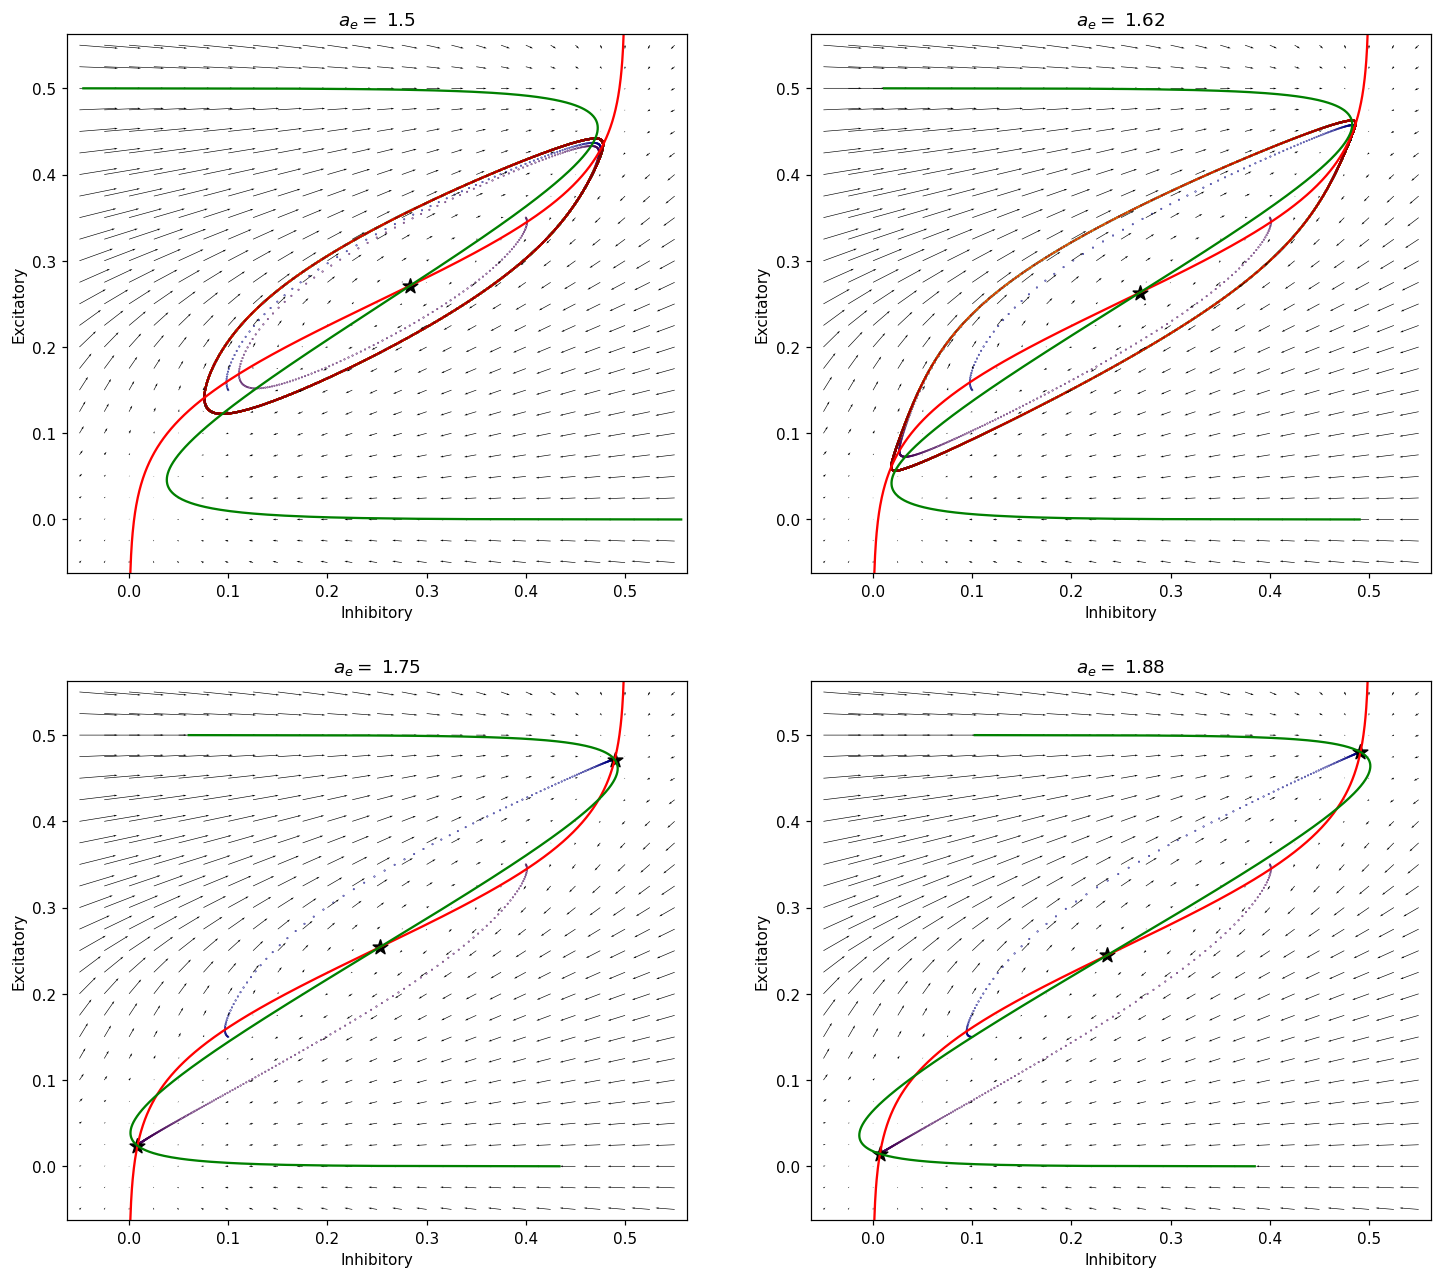

In [146]:
sim_sels = np.arange(parameters.shape[0])
state_space = np.array([[-0.05,0.55],[-0.05,0.55]])
ncols = 2
subplot_size, ms = [8,7], 100
dpi = 110
titles = ["$a_e=$ "+ str(round(parameters[sim_sel,parameter_index_mapping["a_e"]],2)) for sim_sel in sim_sels]

nrows = np.ceil(sim_sels.shape[0]/ncols).astype(int)
fig = plt.figure(figsize = (subplot_size[0]*ncols,subplot_size[1]*nrows),dpi = dpi)
for i, sim_sel in enumerate(sim_sels):
    ax = plt.subplot(nrows,ncols,1+i)
    plt.scatter(tsI[sim_sel],tsE[sim_sel], c = np.arange(tsE[sim_sel].shape[0]), s=0.1, cmap = "viridis")
    plt.scatter(tsI_lowE[sim_sel],tsE_lowE[sim_sel], c = np.arange(tsE_lowE[sim_sel].shape[0]), s=0.1, cmap = "jet")
    Es = np.linspace(state_space[0][0],state_space[0][1],1500)
    Is = np.linspace(state_space[1][0],state_space[1][1],1500)
    Enull = [Is,fn_E_nullcline(Is, parameters[sim_sel],0)]#nullsE[sim_sel]
    Inull = [fn_I_nullcline(Es, parameters[sim_sel],0),Es]##nullsI[sim_sel]
    plt.plot(Enull[0],Enull[1],"-r", lw = 1.5)
    plt.plot(Inull[0],Inull[1],"-g", lw = 1.5)
    plt.scatter(unique_points[sim_sel][:,1].flatten(),unique_points[sim_sel][:,0].flatten(),c="k",marker="*",s=ms)
    Es = np.linspace(state_space[0][0],state_space[0][1],25)
    Is = np.linspace(state_space[1][0],state_space[1][1],25)
    Edot_grid = np.zeros((Es.shape[0],Is.shape[0]))
    Idot_grid = np.zeros((Es.shape[0],Is.shape[0]))
    for j in range(Es.shape[0]):
        Edot_grid[j] = fn_Edot(Es[j],Is,parameters[sim_sel],0)
        Idot_grid[j] = fn_Idot(Es[j],Is,parameters[sim_sel])
    xgrid, ygrid = np.meshgrid(Is,Es)
    flow = plt.quiver(xgrid,ygrid,Idot_grid,Edot_grid, width = 0.001, angles="xy")
    plt.xlim(state_space[1][0]-0.0125,state_space[1][1]+0.0125)
    plt.ylim(state_space[0][0]-0.0125,state_space[0][1]+0.0125)
    plt.xlabel("Inhibitory")
    plt.ylabel("Excitatory")
    plt.title(titles[i])
plt.show()

### Adding noise

In [156]:
parameters[:,-2] = -5

In [157]:
tsE, tsI = simulate_WC_node_ts(parameters, dt=0.25,length=10,is_noise_log_scale=True, store_I=True, initial_conditions=np.array([.35,0.4]))
tsE_lowE, tsI_lowE = simulate_WC_node_ts(parameters, dt=0.25,length=10,is_noise_log_scale=True, store_I=True, initial_conditions=np.array([.15,0.1]))

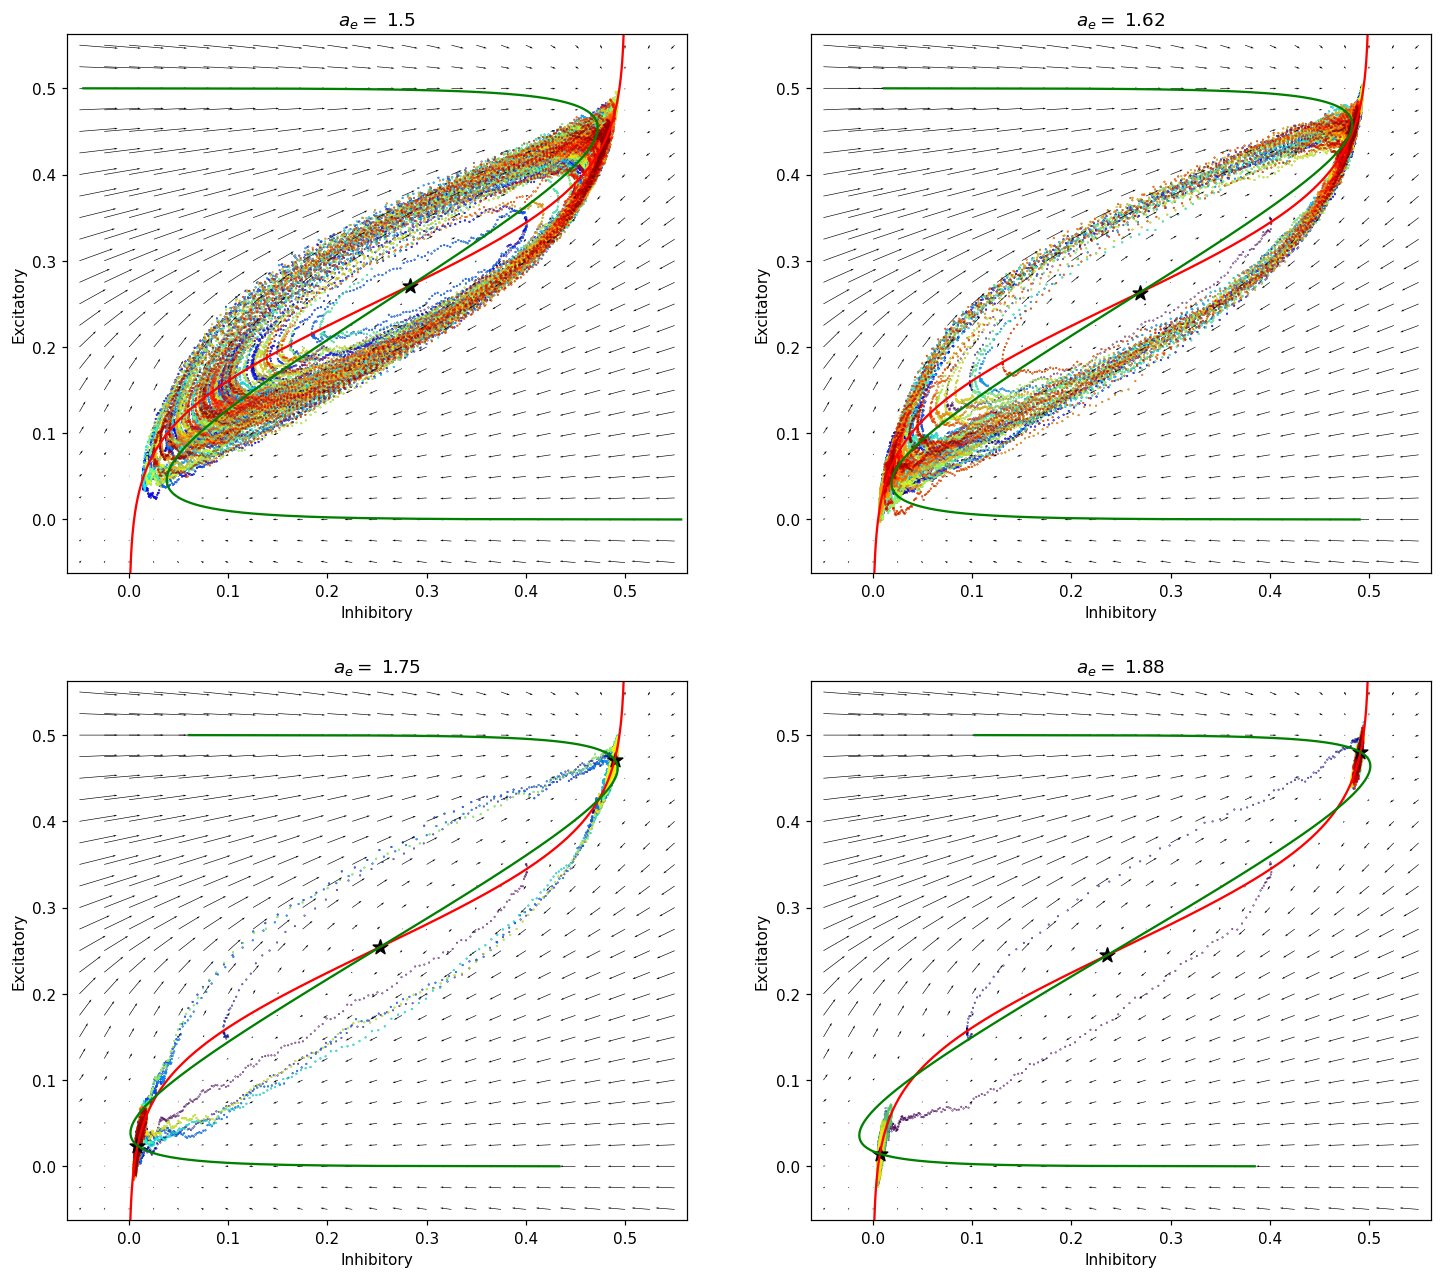

In [158]:
sim_sels = np.arange(parameters.shape[0])
state_space = np.array([[-0.05,0.55],[-0.05,0.55]])
ncols = 2
subplot_size, ms = [8,7], 100
dpi = 110
titles = ["$a_e=$ "+ str(round(parameters[sim_sel,parameter_index_mapping["a_e"]],2)) for sim_sel in sim_sels]

nrows = np.ceil(sim_sels.shape[0]/ncols).astype(int)
fig = plt.figure(figsize = (subplot_size[0]*ncols,subplot_size[1]*nrows),dpi = dpi)
for i, sim_sel in enumerate(sim_sels):
    ax = plt.subplot(nrows,ncols,1+i)
    plt.scatter(tsI[sim_sel],tsE[sim_sel], c = np.arange(tsE[sim_sel].shape[0]), s=0.1, cmap = "viridis")
    plt.scatter(tsI_lowE[sim_sel],tsE_lowE[sim_sel], c = np.arange(tsE_lowE[sim_sel].shape[0]), s=0.1, cmap = "jet")
    Es = np.linspace(state_space[0][0],state_space[0][1],1500)
    Is = np.linspace(state_space[1][0],state_space[1][1],1500)
    Enull = [Is,fn_E_nullcline(Is, parameters[sim_sel],0)]#nullsE[sim_sel]
    Inull = [fn_I_nullcline(Es, parameters[sim_sel],0),Es]##nullsI[sim_sel]
    plt.plot(Enull[0],Enull[1],"-r", lw = 1.5)
    plt.plot(Inull[0],Inull[1],"-g", lw = 1.5)
    plt.scatter(unique_points[sim_sel][:,1].flatten(),unique_points[sim_sel][:,0].flatten(),c="k",marker="*",s=ms)
    Es = np.linspace(state_space[0][0],state_space[0][1],25)
    Is = np.linspace(state_space[1][0],state_space[1][1],25)
    Edot_grid = np.zeros((Es.shape[0],Is.shape[0]))
    Idot_grid = np.zeros((Es.shape[0],Is.shape[0]))
    for j in range(Es.shape[0]):
        Edot_grid[j] = fn_Edot(Es[j],Is,parameters[sim_sel],0)
        Idot_grid[j] = fn_Idot(Es[j],Is,parameters[sim_sel])
    xgrid, ygrid = np.meshgrid(Is,Es)
    flow = plt.quiver(xgrid,ygrid,Idot_grid,Edot_grid, width = 0.001, angles="xy")
    plt.xlim(state_space[1][0]-0.0125,state_space[1][1]+0.0125)
    plt.ylim(state_space[0][0]-0.0125,state_space[0][1]+0.0125)
    plt.xlabel("Inhibitory")
    plt.ylabel("Excitatory")
    plt.title(titles[i])
plt.show()

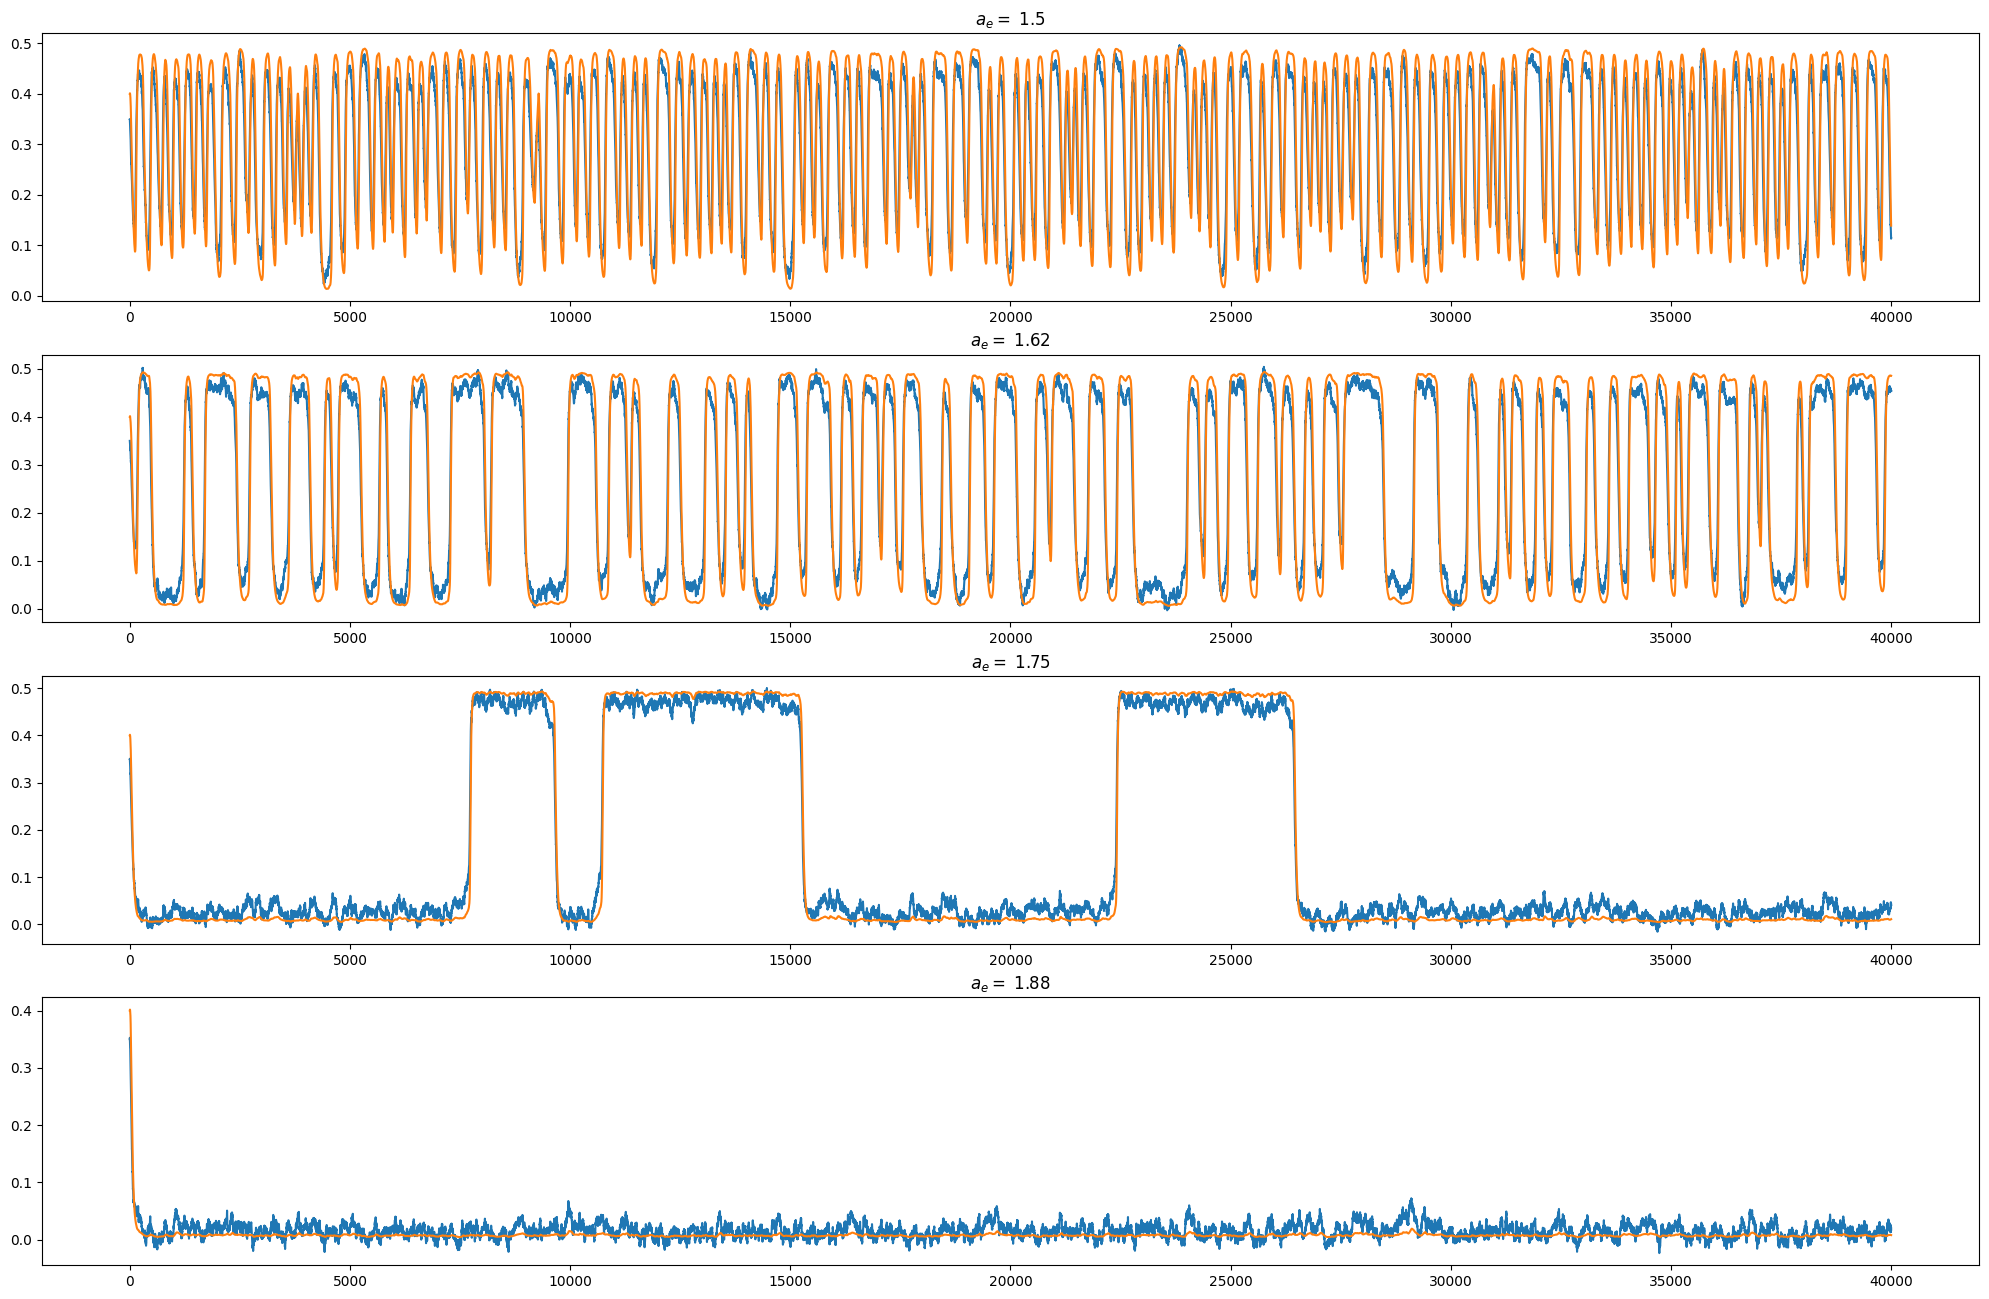

In [159]:
sim_sels = np.arange(parameters.shape[0])
titles = ["$a_e=$ "+ str(round(parameters[sim_sel,parameter_index_mapping["a_e"]],2)) for sim_sel in sim_sels]
fig = plt.figure(figsize = (25,4*sim_sels.shape[0]))
for i, sim_sel in enumerate(sim_sels):
    ax = plt.subplot(sim_sels.shape[0],1,1+i)
    plt.plot(tsE[sim_sel])
    plt.plot(tsI[sim_sel])
    plt.title(titles[i])
plt.show()